# Blog content (classifying flowers)

In [1]:
# The following is a temporary patch to fix a bug with VS Code displaying
# progress bars for Jupyter notebooks
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

## Step 1: Load dataset

This will use the [Flowers Recognition](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition?resource=download) dataset from Kaggle, which contains approximately 800 photos of 5 types of flowers: chamomile, tulip, rose, sunflower, dandelion.

The dataset doesn't split into training and testing, so I've done this manually by separating the first 50 images of each class into a test set.

In [2]:
from fastcore.all import *
from fastai.vision.all import *

path = Path('..', 'data', 'flowers', 'train')

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(224, method='squish')]
).dataloaders(path)

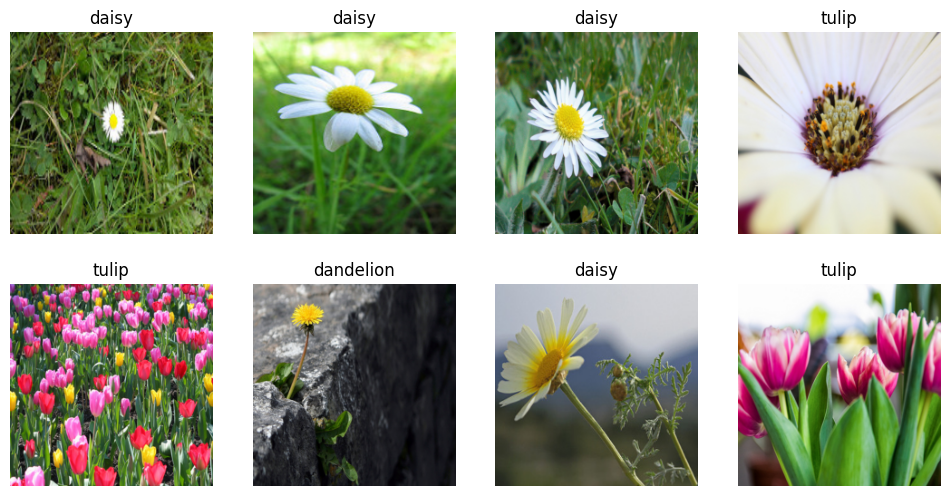

In [20]:
dls.show_batch(max_n=8)

## Step 2: Train classifier

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

# Instead of fine-tuning again, we could also load a model trained and saved previously
# learn.load('resnet18-flowers-tuned')

epoch,train_loss,valid_loss,error_rate,time
0,0.419961,0.383622,0.108241,00:18
1,0.224949,0.312548,0.095941,00:18
2,0.111067,0.301007,0.089791,00:18


In [14]:
learn.save(file='resnet18-flowers-tuned')

Path('models/resnet18-flowers-tuned.pth')

## Step 3: Test classifier

In [15]:
test_path = Path(path, '..', 'test')
test_dl = learn.dls.test_dl(get_image_files(test_path), with_labels=True)
_, preds, _ = learn.get_preds(dl=test_dl, with_decoded=True)

preds = preds.numpy()
labels = np.array([0]*50 + [1]*50 + [2]*50 + [3]*50 + [4]*50)

In [16]:
correct = sum(preds == labels)
total = len(labels)
acc = 100 * sum(preds == labels) / len(labels)

print(f'Test accuracy: {acc:.2f}% ({correct}/{total})')

Test accuracy: 100.00% (250/250)


## Step 4: Visualise classification

In [17]:
# Reload the model before cutting so this cell can be re-run without issue
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.load('resnet18-flowers-tuned')

# Cut the model right before the classification layer
new_head = cut_model(learn.model[-1], 2)
learn.model[-1] = new_head
learn.model.cuda()

# Run data through the new network to derive the feature vectors
x, y = dls.one_batch()
feature_vectors = learn.model(x)

In [18]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(feature_vectors.cpu().detach().numpy())

Text(0.5, 1.0, 't-SNE model visualisation')

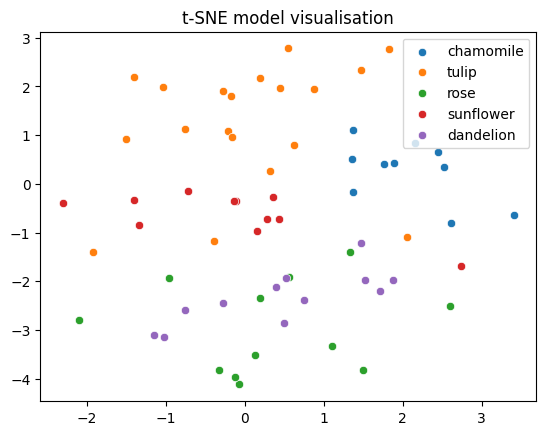

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = y.cpu().numpy()

_, ax = plt.subplots()

flowers = ['chamomile', 'tulip', 'rose', 'sunflower', 'dandelion']

for i in range(len(flowers)):
    sns.scatterplot(x=tsne[:, 0][labels == i], y=tsne[:, 1][labels == i],
        label=flowers[i], ax=ax)

ax.set_title('t-SNE model visualisation')